In [49]:
import os
import cv2
import random
from datetime import datetime

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.core import Flatten
from keras.layers.merge import Concatenate
import keras
from utils.vqa_tools.PythonHelperTools.vqaTools.vqa import VQA

# Set VQA dataset files and parameters
# dataDir='/Volumes/Data/vqa_data'
dataDir='vqa_data'
taskType='OpenEnded'
dataType='mscoco' # 'mscoco' for real and 'abstract_v002' for abstract
dataSubType='train2014'
annFile='%s/Annotations/v2_%s_%s_annotations.json'%(dataDir, dataType, dataSubType)
quesFile='%s/Questions/v2_%s_%s_%s_questions.json'%(dataDir, taskType, dataType, dataSubType)
imgDir = '%s/Images/%s/' %(dataDir, dataSubType)

def get_Inception_v3_pre_trained_model():
    
# a = Input((76,56,1))
# b = Flatten()(a)
# c = Dense(100)(b)
# m = Model(a,c)
# m.summary()


#     vision_model = Sequential()
    print('{} - Starting to get base inception v3 model'.format(datetime.now()))
    inception_base_model = InceptionV3(weights='imagenet', include_top=False)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in inception_base_model.layers:
        layer.trainable = False
        
    print('inception_base_model.summary: ', inception_base_model.summary())
#     vision_model = Flatten()(inception_base_model.output)
    x = inception_base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.8)(x)
    feature = Dense(512)(x)

    
#     print('{} - Adding base model'.format(datetime.now()))
#     vision_model.add(inception_base_model)
    
    
#      inception_base_model = add(Flatten())
    
    image_input = Input(shape=(229, 229, 3))
    inception_model = Model(inputs=inception_base_model.input, output=feature)
#     encoded_image = vision_model(image_input)
    encoded_image = inception_model(image_input)
    
    print('{} - Processing embedded model'.format(datetime.now()))
    question_input = Input(shape=(100,), dtype='int32')
    embedded_question = Embedding(input_dim=10000, output_dim=512, input_length=30)(question_input)
    encoded_question = LSTM(256)(embedded_question)
    
    # Let's concatenate the question vector and the image vector:
#     merged = keras.layers.concatenate([encoded_question, encoded_image])
    print('{} - Merging model'.format(datetime.now()))
    merged = keras.layers.concatenate([encoded_question, encoded_image])

    # And let's train a logistic regression over 1000 words on top:
    output = Dense(1000, activation='softmax')(merged)

    # This is our final model:
    print('{} - final model'.format(datetime.now()))
    vqa_model = Model(inputs=[image_input, question_input], outputs=output)
    
    
    
    return vqa_model
    

In [50]:
print('{} - Loading VQA dataset'.format(datetime.now()))
vqa = VQA(annFile, quesFile)
annIds = vqa.getQuesIds(quesTypes='how many');
anns = vqa.loadQA(annIds)
# print("answer from anns: ", anns[0]['answers'][0]['answer'])
print("answer(random) from anns: ", random.choice(anns[0]['answers'])['answer'])
# print("anser from qa: ", vqa.qa[393227002]['answers'][0]['answer'])
print("querstoin from qqa: ", vqa.qqa[anns[0]['question_id']]['question'])


2017-08-04 03:09:27.801513 - Loading VQA dataset
loading VQA annotations and questions into memory...
0:00:14.600221
creating index...
index created!
answer(random) from anns:  1
querstoin from qqa:  How many tattoos can be seen on this man's body?


(299, 299, 3)


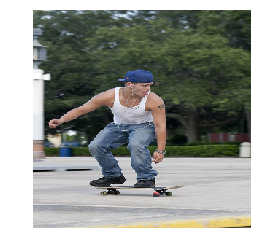

In [51]:
image_list = []
question_list = []
answer_list = []



question_list.append(vqa.qqa[anns[0]['question_id']]['question'])
answer_list.append(random.choice(anns[0]['answers'])['answer']) 

imgId = anns[0]['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'



file = imgDir + imgFilename
if os.path.isfile(file):
#     im = cv2.resize(cv2.imread(file), (299, 299))
#     im = im.astype(np.float32, copy=False)
    
    im = np.asarray(cv2.imread(file))[:,:,::-1]
#     im = central_crop(im, 0.875)
    im = cv2.resize(im, (299, 299))
#     im = im.reshape(-1,299,299,3)
    
#     im = io.imread(file)
    
    print(im.shape)
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    image_list.append(im)

# if os.path.isfile(imgDir + imgFilename):
#     I = io.imread(imgDir + imgFilename)
#     plt.imshow(I)
#     plt.axis('off')
#     plt.show()


In [52]:

verbose = 1
if verbose: print("\n\n\nLoading model .......")
model = get_Inception_v3_pre_trained_model()

# Training
epoch = 1
batch_size = 1

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
if verbose: print("\n\n\nTraining model .......")
train_history = model.fit(x=[image_list, question_list], y=answer_list, 
                              epochs=epoch, batch_size=batch_size, verbose=2)
if verbose: print("\n\n\nDone.......")




Loading model .......
2017-08-04 03:10:09.154315 - Starting to get base inception v3 model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_24 (InputLayer)            (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1129 (Conv2D)             (None, None, None, 32 864         input_24[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1129 (BatchN (None, None, None, 32 96          conv2d_1129[0][0]                
____________________________________________________________________________________________________
activation_1129 (Activation)     (None, None, None, 32 0           batch_normalization_1129[0][0] 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


____________________________________________________________________________________________________
conv2d_1155 (Conv2D)             (None, None, None, 38 995328      mixed2[0][0]                     
____________________________________________________________________________________________________
conv2d_1158 (Conv2D)             (None, None, None, 96 82944       activation_1157[0][0]            
____________________________________________________________________________________________________
batch_normalization_1155 (BatchN (None, None, None, 38 1152        conv2d_1155[0][0]                
____________________________________________________________________________________________________
batch_normalization_1158 (BatchN (None, None, None, 96 288         conv2d_1158[0][0]                
____________________________________________________________________________________________________
activation_1155 (Activation)     (None, None, None, 38 0           batch_normalization_1155

2017-08-04 03:10:46.298577 - Merging model
2017-08-04 03:10:46.332965 - final model



Training model .......


AttributeError: 'list' object has no attribute 'shape'